In [21]:
import os
from PIL import Image

In [22]:
keeps = [ 'sword', 'pickaxe', 'axe']#, 'hoe', 'shovel' ]
# keeps = ['sword', 'pickaxe']
data = 'minecraft'
SIZE = 32

# reset the data directory
for file in os.listdir(data):
    os.remove(f"{data}/{file}")

for root, dirs, files in os.walk("textures"):
    # pack = root.split(os.sep)[-1]
    pack = root.split('textures/')[-1].replace('/', '-')

    # skip folders that end with '.disabled'
    if ".disabled" in pack:
        continue

    for file in files:
        if file.endswith(".png"):
            # skip normal maps
            if file.endswith("_n.png"):
                print(f"Skipping {root}/{file} because it is a normal map")
                continue

            if file.endswith("_s.png"):
                print(f"Skipping {root}/{file} because it is a specular map")
                continue
            
            if file.endswith("_e.png"):
                print(f"Skipping {root}/{file} because it is an emissive map")
                continue

            # TODO other possible types of maps

            # skip empty images
            if 'empty' in file:
                print(f"Skipping {root}/{file} because it is empty")
                continue

            for keep in keeps:
                if f"_{keep}" in file:
                    # skip if not a stone item
                    if 'stone' not in file:
                        print(f"Skipping {root}/{file} because it is not a stone item")
                        continue

                    # skip the file if it is not 32x32
                    try:
                        img = Image.open(f"{root}/{file}")
                        if img.size[0] != img.size[1]:
                            print(f"Skipping {root}/{file} because it is not a square ({img.size})")
                            continue
                        if img.size[0] < SIZE:
                            print(f"skipping {root}/{file} because it is not 32x32 ({img.size})")
                            continue

                        os.system(f"cp {root}/{file} {data}/{pack}-{file}")
                    except Exception as e:
                        print(f"Skipping {root}/{file} because it is not an image: {e}")
                    

Skipping textures/helios/netherite_sword.png because it is not a stone item
Skipping textures/helios/wooden_axe.png because it is not a stone item
Skipping textures/helios/wooden_sword.png because it is not a stone item
Skipping textures/helios/golden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_axe.png because it is not a stone item
Skipping textures/helios/netherite_pickaxe.png because it is not a stone item
Skipping textures/helios/diamond_pickaxe.png because it is not a stone item
Skipping textures/helios/wooden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_sword.png because it is not a stone item
Skipping textures/helios/diamond_axe.png because it is not a stone item
Skipping textures/helios/iron_pickaxe.png because it is not a stone item
Skipping textures/helios/netherite_axe.png because it is not a stone item
Skipping textures/helios/iron_sword.png because it is not a stone item
Skipping textures/helios/diamond_sword.png

In [23]:
# replace the alpha channel with a solid color using pil
for file in os.listdir(data):
    if file.endswith(".png"):
        img = Image.open(f"{data}/{file}")
        img = img.convert("RGBA")

        if img.size[0] > SIZE:
            print(f"resizing {root}/{file} because it is not {SIZE}x{SIZE} ({img.size})")
            img = img.resize((SIZE, SIZE)) # TODO Image.NearestNeighbour
            img.save(f"{root}/{file}")

        datas = img.getdata()
        new_data = []
        for item in datas:
            if item[3] == 0:
                # if the pixel is transparent, replace it with white
                new_data.append((255, 255, 255, 255))
            else:
                new_data.append(item)
        img.putdata(new_data)
        img.save(f"{data}/{file}", "PNG")
        # break

resizing textures/StevensTraditional/models/WolfhoundFantasy-stone_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-stone_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_sword_broken.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-stone_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/ZigZag-stone_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Grove-stone_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Grove-stone_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/I

In [24]:
# convert the files into a dataset using the dataset lib
import numpy as np

labels = {
    'sword': 0,
    'pickaxe': 1,
    'axe': 2,
    'hoe': 3,
    'shovel': 4
}

def get_label(file):
    if 'sword' in file:
        return 0
    if 'pickaxe' in file:
        return 1
    if 'axe' in file:
        return 2
    if 'hoe' in file:
        return 3
    if 'shovel' in file:
        return 4
    
    # throw an error if the label is not found
    raise Exception(f"Label not found for {file}")

# load the images
dataset = []
for file in os.listdir(data):
    if file.endswith(".png"):
        # img = Image.open(f"{data}/{file}")
        # open the image in black and white
        img = Image.open(f"{data}/{file}")#.convert("L")
        # drop the alpha channel
        img = img.convert("RGB")
        # load image into numpy array and normalize
        img = np.array(img) / 255
        dataset.append((img, get_label(file)))

# create the dataset
# images_np = np.array(images)
# images_np = images_np.reshape((images_np.shape[0], 32, 32, 4))
# print(images_np.shape)

# dataset = (images_np, labels)

# store the dataset into a pickle file
import pickle
pickle.dump(dataset, open("mc-dataset.pkl", "wb"))

In [25]:
#%pip install fastai

In [26]:
import numpy as np
import fastai
import matplotlib.pyplot as plt

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [27]:
bs = 16
size = 32

In [28]:
%matplotlib inline

In [29]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop),
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
                  )

In [30]:
# load data from local path
path = 'minecraft'
dls = dblock.dataloaders(path, path=path, bs=bs)
len(dls.train.dataset)
print(type(dls))

<class 'fastai.data.core.DataLoaders'>


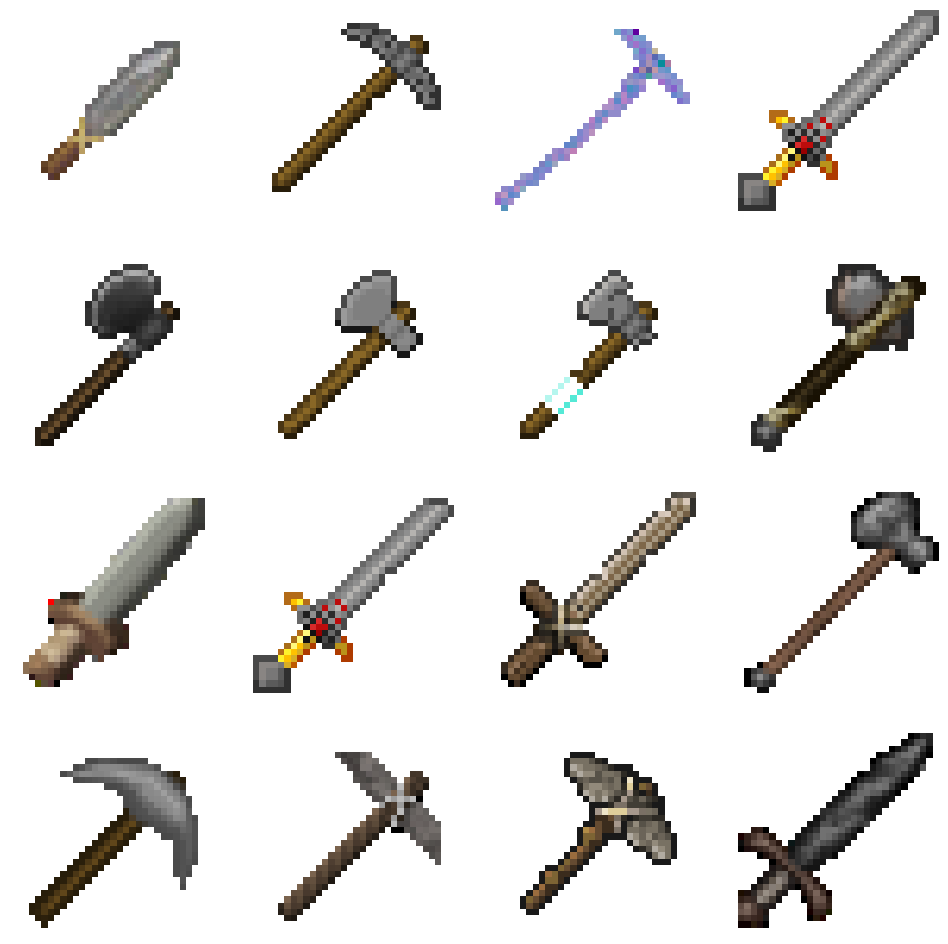

In [31]:
dls.show_batch(max_n=16)

In [32]:
generator = basic_generator(32, n_channels=3, n_extra_layers=1)

critic    = basic_critic(
                    32, 
                    n_channels=3, 
                    n_extra_layers=1, 
                    act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
)

In [33]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [34]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [35]:
# create a callback to print the gan stats every 10 iterations
class PrintLoss(Callback):
    def after_batch(self):
        if self.iter % 10 == 0:
            gen_loss = self.learn.recorder.losses[-2] if len(self.learn.recorder.losses) > 2 else 0
            crit_loss = self.learn.recorder.losses[-1] if len(self.learn.recorder.losses) > 1 else 0
            # print(f'iter {self.iter} | gen_loss {gen_loss:.4f} | crit_loss {crit_loss:.4f}')

In [36]:
with learn.no_logging():
    learn.fit(100, 2e-4, wd=0., cbs=[PrintLoss()])

KeyboardInterrupt: 

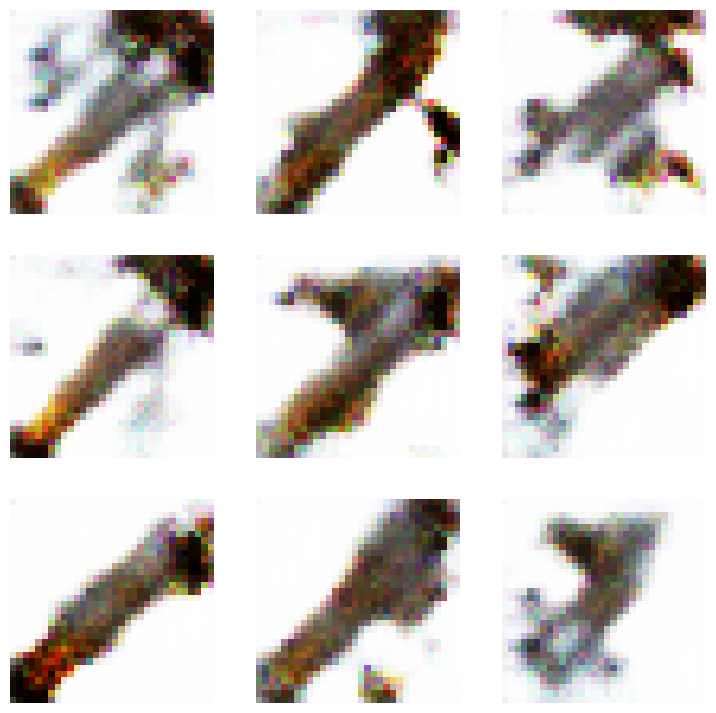

In [ ]:
## matplotlib inline
learn.show_results(max_n=9, ds_idx=0)
## %matplotlib inline
## plt.show()

In [ ]:
# create random y vector where each y is a random number between 0 and 10
classes = 10
batch = 8
y = torch.randint(0, classes, (1, batch))
y = F.one_hot(y, num_classes=classes).squeeze(0)
print(y)

# create a batch of random noise
noise = torch.randn(batch, 100)
# create a batch of random ohe class labels
y = torch.randint(0, classes, (1, batch))

# concatenate the noise and the class labels
z = torch.cat([noise, y.float()], dim=1)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 1 for tensor number 1 in the list.

In [61]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
# model = BertForSequenceClassification.from_pretrained("google/bert_uncased_L-12_H-128_A-2", classes=10)
# create a sentence similarity model
print(classes)
model = BertForSequenceClassification.from_pretrained("google/bert_uncased_L-2_H-128_A-2", num_labels=18)
print(model.config.num_labels)
print(model.config)
print(tokenizer.vocab_size)

# do a forward pass
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = model(**inputs, labels=labels)
# loss = outputs.loss
# logits = outputs.logits
# print(loss)

# do a simple sentence similarity
inputs = tokenizer("wooden sword", return_tensors="pt")
outputs = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state

inputs = tokenizer("baby cat", return_tensors="pt")
outputs1 = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state
print ('#################')
print(outputs1)
print(outputs[0].detach().numpy())

# find the similarity between the two sentences
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(outputs[0].detach().numpy(), outputs1[0].detach().numpy()))


10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


18
BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-128_A-2",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL_16": 16,
    "LABEL_17": 17,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL

In [68]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# Load model
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", classes=18)

# do a simple sentence similarity
inputs = tokenizer("wooden sword", return_tensors="pt")
outputs = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state

inputs = tokenizer("stone sword", return_tensors="pt")
outputs2 = model(**inputs) # ugh my test code is in there

inputs = tokenizer("baby cat", return_tensors="pt")
outputs1 = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state
print ('#################')
print(outputs1)
print(outputs)
print(outputs2)



TypeError: __init__() got an unexpected keyword argument 'classes'

In [80]:
#%pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer, util
sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)

# change the size of the embeddings to 1x18
compressor = nn.Linear(384, 18).to('mps')
embedding_1 = compressor(embedding_1)
embedding_2 = compressor(embedding_2)
embedding_3 = compressor(embedding_3)
embedding_4 = compressor(embedding_4)

print('#################')
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
## tensor([[0.6003]])


hidden_states[0][0][:8]=tensor([-0.0018421225, -0.0170202535, -0.0162563194,  0.0286704935,
        -0.0069405884, -0.0030475128, -0.0529528745, -0.0304223560],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0453220829,  0.0115450099, -0.0138783697, -0.0002473481,
        -0.0138992723, -0.0105863921, -0.0454283059, -0.0008730106],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0177409835, -0.0120303966, -0.0141230803,  0.0119713005,
        -0.0205599591, -0.0120695401, -0.0070637092, -0.0126050357],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0092920102,  0.0134178409,  0.0020901016,  0.0102851158,
        -0.0459468439, -0.0136107169, -0.0666975528, -0.0076797409],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0335627906,  0.0264742933, -0.0120933130, -0.0096576056,
        -0.0569915622, -0.0029180739, -0.0545790493, -0.0593914315],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.1401357502,  0.2689611614,  0.2982816994,  0.